In [10]:
from glob import glob
import numpy as np
import random
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt

from python import solar_utils as su
from python import utils as pu

## Bias-correction

### Analysis

In [6]:
%%time
# Get solar paths
climate_paths = glob(f"{pu.tgw_path}/historical_1980_2019/hourly/tgw_wrf_historical_hourly_2006*.nc")

# Get TGW input solar data
df = su.prepare_solar_data(
    climate_paths = climate_paths,
    solar_vars = ['T2C', 'SWDOWN'],
    lat_name="south_north",
    lon_name="west_east",
    curvilinear=True,
)

CPU times: user 51.3 s, sys: 2.31 s, total: 53.6 s
Wall time: 4min 28s


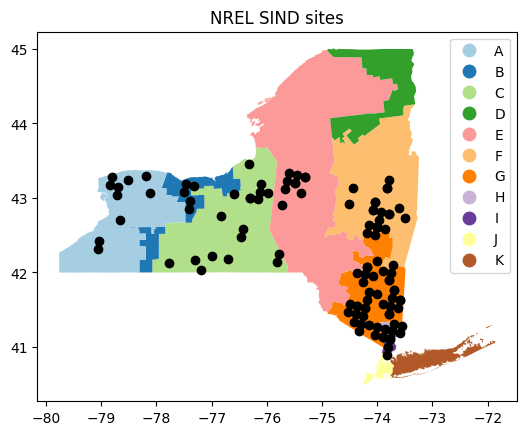

In [8]:
# Show locations of all SIND solar sites
gdf = su.merge_to_zones(df[(df['dayofyear'] == 1) & (df['hour'] == 12)])

# Load NYISO
nyiso_gdf = gpd.read_file(f"{pu.project_path}/data/nyiso/shapefiles/NYISO_Load_Zone_Dissolved.shp")

# Plot
fig, ax = plt.subplots()
nyiso_gdf.plot(column='ZONE', legend=True, cmap='Paired', ax=ax)
gdf['geometry'].plot(color='black', ax=ax)
ax.set_title('NREL SIND sites')
plt.savefig('../../figs/nrel_sind_sites.png', dpi=300, bbox_inches='tight')

In [9]:
# Get optimal beta with correction
# Default was 0.45
optimized_beta = su.optimize_beta(
    df = df,
    temperature_var = "T2C",
    shortwave_var = "SWDOWN"
)
print(f"Optimized beta: {optimized_beta:.2f}")

Optimized beta: 1.31


In [10]:
# Get TGW correction factors
df, df_correction = su.get_solar_correction_factors(
    df = df,
    temperature_var = 'T2C',
    shortwave_var = 'SWDOWN',
    beta = optimized_beta,
)

In [11]:
# Store correction factors with beta
df_correction['optimized_beta'] = optimized_beta
df_correction.to_csv(f"{pu.project_path}/data/models/tgw_solar_correction_factors.csv")

In [14]:
df_correction

bias_correction  optimized_beta
month hour                                 
1     0            0.000000        1.308329
      1            0.000000        1.308329
      2            0.000000        1.308329
      3            0.000000        1.308329
      4            0.000000        1.308329
...                     ...             ...
12    19          -0.095148        1.308329
      20          -0.092373        1.308329
      21          -0.045554        1.308329
      22           0.000000        1.308329
      23           0.000000        1.308329

[288 rows x 2 columns]

### Plots

In [15]:
# Non-zero solar indices
inds = df['actual_power_norm'] > 0.0

# Baseline RMSE
df['sim_power_norm_baseline'] = su.calculate_solar_power(df['SWDOWN'], df['T2C'])
base_rmse = np.sqrt(np.mean((df['sim_power_norm_baseline'] - df['actual_power_norm'])**2))
base_rmse_nonzero = np.sqrt(np.mean((df[inds]['sim_power_norm_baseline'] - df[inds]['actual_power_norm'])**2))
print(f"Baseline RMSE: {base_rmse:.3f}")
print(f"Baseline RMSE (non-zero): {base_rmse_nonzero:.3f}")

# Optimized beta plus bias-correction
opt_rmse = np.sqrt(np.mean((df['sim_power_norm_corrected'] - df['actual_power_norm'])**2))
opt_rmse_nonzero = np.sqrt(np.mean((df[inds]['sim_power_norm_corrected'] - df[inds]['actual_power_norm'])**2))
print(f"Optimized RMSE: {opt_rmse:.4f}")
print(f"Optimized RMSE (non-zero): {opt_rmse_nonzero:.3f}")

Baseline RMSE: 0.149
Baseline RMSE (non-zero): 0.212
Optimized RMSE: 0.0966
Optimized RMSE (non-zero): 0.139


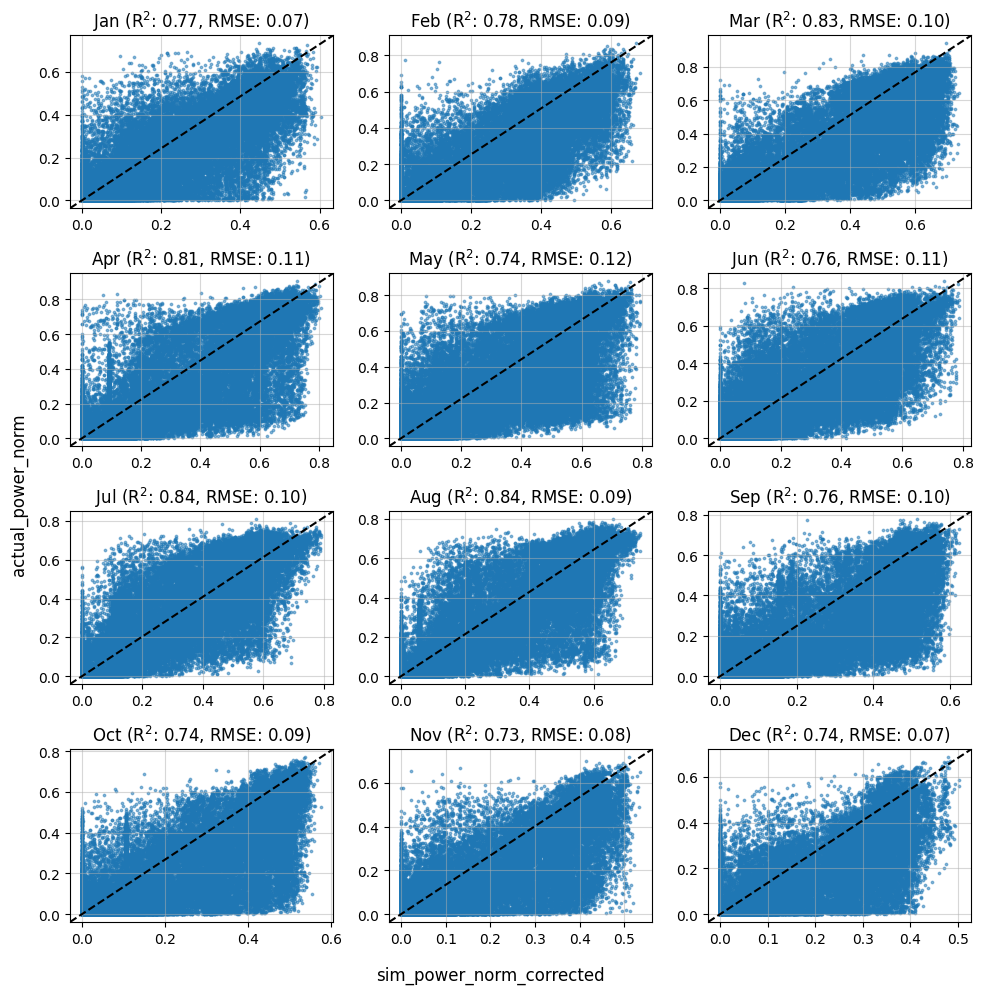

In [16]:
# Scatter
su.plot_solar_correction_fit(df, 
                             x_col='sim_power_norm_corrected', 
                             y_col='actual_power_norm',
                             save_path = '../../figs/solar_fit.png')

In [19]:
# Get unique locations
upv_latlons = df[df['solar_type'] == 'UPV'][['sind_lat', 'sind_lon']].value_counts().index.unique()
dpv_latlons = df[df['solar_type'] == 'DPV'][['sind_lat', 'sind_lon']].value_counts().index.unique()

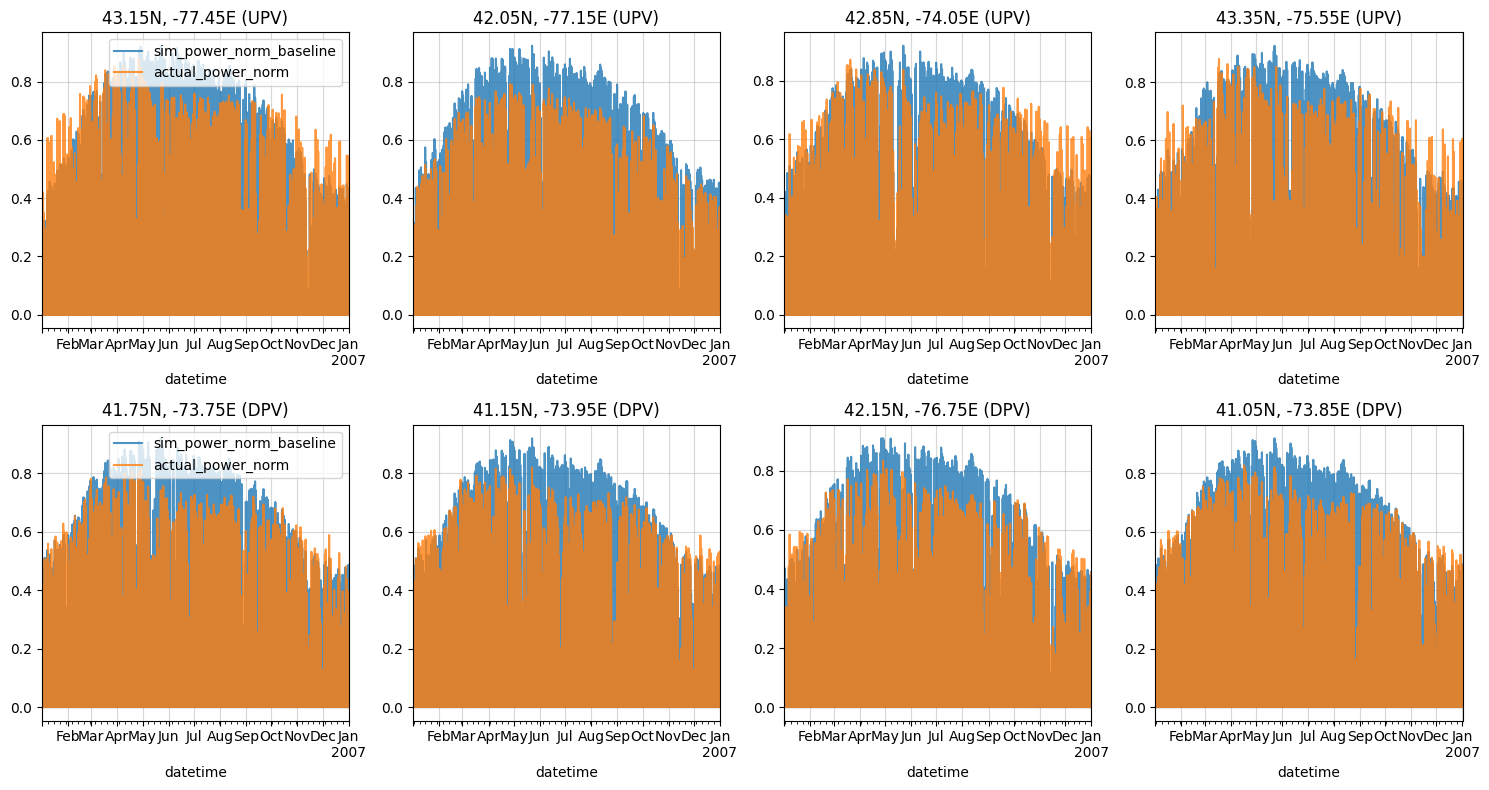

In [20]:
# Example plot: baseline
n = 4
fig, axs = plt.subplots(2, n, figsize=(15,8))

# UPV
for idl, latlon in enumerate(np.random.choice(upv_latlons, size=n)):
    ax = axs[0,idl]
    lat, lon = latlon
    df[(df['solar_type'] == 'UPV') & (df['sind_lat'] == lat) & (df['sind_lon'] == lon)].plot(x='datetime', y='sim_power_norm_baseline', ax=ax, alpha=0.8, legend=(idl==0))
    df[(df['solar_type'] == 'UPV') & (df['sind_lat'] == lat) & (df['sind_lon'] == lon)].plot(x='datetime', y='actual_power_norm', ax=ax, alpha=0.8, legend=(idl==0))

    ax.set_title(f"{lat}N, {lon}E (UPV)")
    ax.grid(alpha=0.5)

# DPV
for idl, latlon in enumerate(np.random.choice(dpv_latlons, size=n)):
    ax = axs[1,idl]
    lat, lon = latlon
    df[(df['solar_type'] == 'DPV') & (df['sind_lat'] == lat) & (df['sind_lon'] == lon)].plot(x='datetime', y='sim_power_norm_baseline', ax=ax, alpha=0.8, legend=(idl==0))
    df[(df['solar_type'] == 'DPV') & (df['sind_lat'] == lat) & (df['sind_lon'] == lon)].plot(x='datetime', y='actual_power_norm', ax=ax, alpha=0.8, legend=(idl==0))

    ax.set_title(f"{lat}N, {lon}E (DPV)")
    ax.grid(alpha=0.5)

plt.tight_layout()
plt.show()

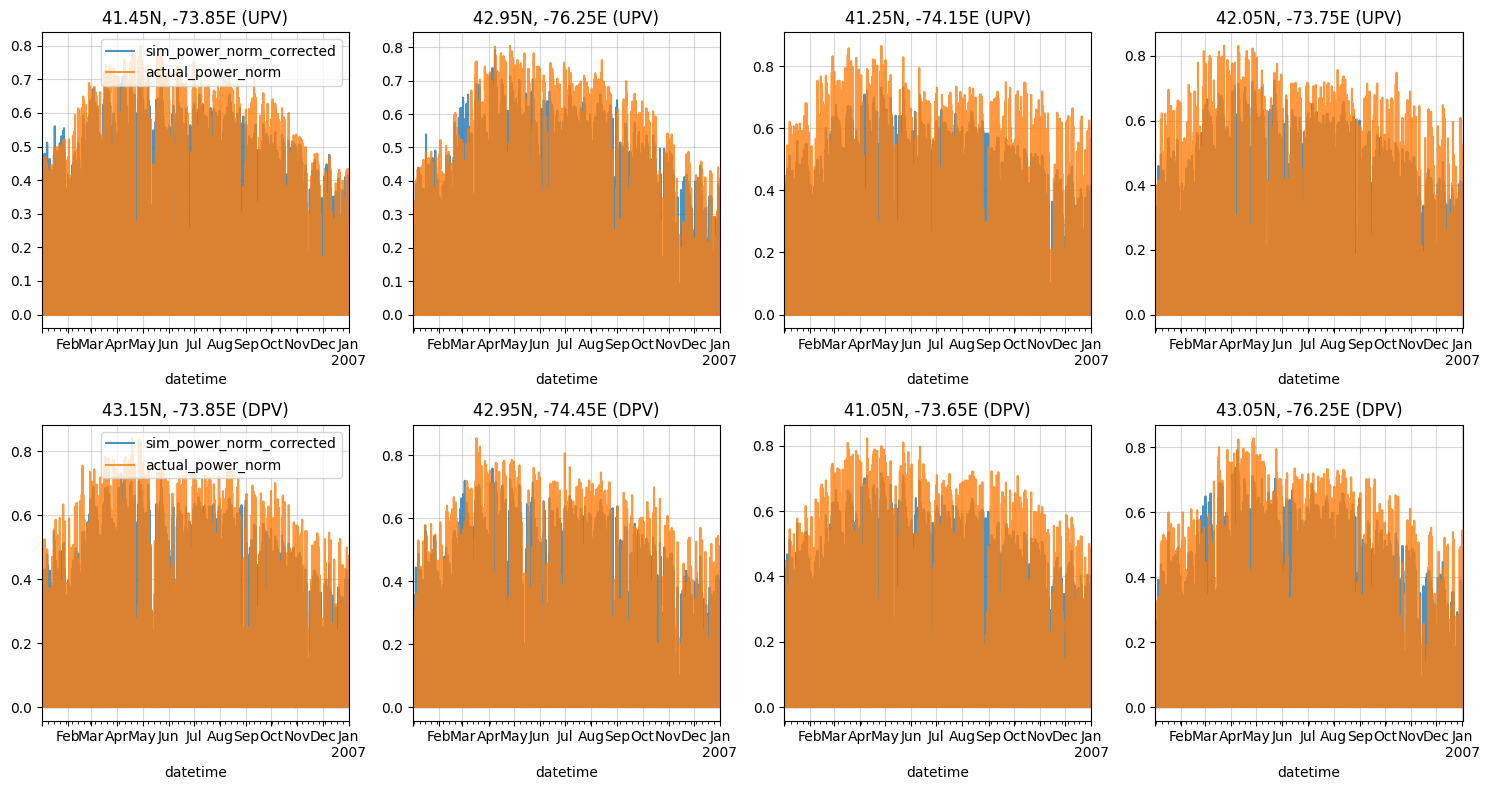

In [21]:
# Example plot: corrected
n = 4
fig, axs = plt.subplots(2, n, figsize=(15,8))

# UPV
for idl, latlon in enumerate(np.random.choice(upv_latlons, size=n)):
    ax = axs[0,idl]
    lat, lon = latlon
    df[(df['solar_type'] == 'UPV') & (df['sind_lat'] == lat) & (df['sind_lon'] == lon)].plot(x='datetime', y='sim_power_norm_corrected', ax=ax, alpha=0.8, legend=(idl==0))
    df[(df['solar_type'] == 'UPV') & (df['sind_lat'] == lat) & (df['sind_lon'] == lon)].plot(x='datetime', y='actual_power_norm', ax=ax, alpha=0.8, legend=(idl==0))

    ax.set_title(f"{lat}N, {lon}E (UPV)")
    ax.grid(alpha=0.5)

# DPV
for idl, latlon in enumerate(np.random.choice(dpv_latlons, size=n)):
    ax = axs[1,idl]
    lat, lon = latlon
    df[(df['solar_type'] == 'DPV') & (df['sind_lat'] == lat) & (df['sind_lon'] == lon)].plot(x='datetime', y='sim_power_norm_corrected', ax=ax, alpha=0.8, legend=(idl==0))
    df[(df['solar_type'] == 'DPV') & (df['sind_lat'] == lat) & (df['sind_lon'] == lon)].plot(x='datetime', y='actual_power_norm', ax=ax, alpha=0.8, legend=(idl==0))

    ax.set_title(f"{lat}N, {lon}E (DPV)")
    ax.grid(alpha=0.5)

plt.tight_layout()
plt.show()

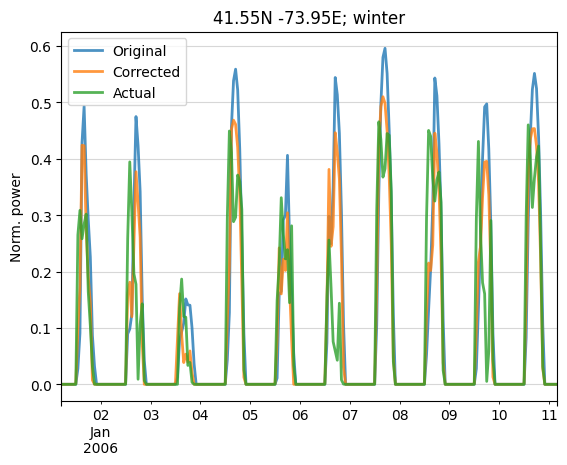

In [22]:
# Example plot: winter
lat, lon = upv_latlons[10]
istart = 0
nsteps = 24*10
fig, ax = plt.subplots()
df[(df['sind_lat'] == lat) & (df['sind_lon'] == lon)][istart:istart+nsteps].plot(x='datetime', y='sim_power_norm', ax=ax, alpha=0.8, lw=2, label='Original')
df[(df['sind_lat'] == lat) & (df['sind_lon'] == lon)][istart:istart+nsteps].plot(x='datetime', y='sim_power_norm_corrected', ax=ax, alpha=0.8, lw=2, label='Corrected')
df[(df['sind_lat'] == lat) & (df['sind_lon'] == lon)][istart:istart+nsteps].plot(x='datetime', y='actual_power_norm', ax=ax, alpha=0.8, lw=2, label='Actual')

ax.set_title(f"{lat}N {lon}E; winter")
ax.set_xlabel('')
ax.set_ylabel('Norm. power')
ax.grid(alpha=0.5)

plt.savefig('../../figs/solar_example_winter.png', dpi=300, bbox_inches='tight')

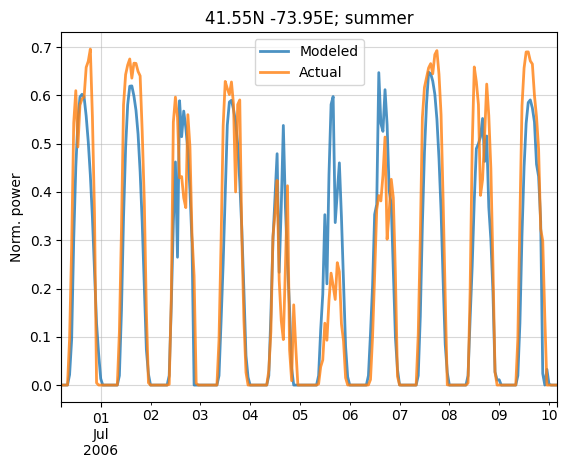

In [23]:
# Example plot: summer
lat, lon = upv_latlons[10]
istart = 180*24
nsteps = 24*10
fig, ax = plt.subplots()
df[(df['sind_lat'] == lat) & (df['sind_lon'] == lon)][istart:istart+nsteps].plot(x='datetime', y='sim_power_norm_corrected', ax=ax, alpha=0.8, lw=2, label='Modeled')
df[(df['sind_lat'] == lat) & (df['sind_lon'] == lon)][istart:istart+nsteps].plot(x='datetime', y='actual_power_norm', ax=ax, alpha=0.8, lw=2, label='Actual')

ax.set_title(f"{lat}N {lon}E; summer")
ax.set_xlabel('')
ax.set_ylabel('Norm. power')
ax.grid(alpha=0.5)

plt.savefig('../../figs/solar_example_summer.png', dpi=300, bbox_inches='tight')